<a href="https://colab.research.google.com/github/fuyu-quant/Data_Science/blob/main/Time_Series_Analysis/AutoGluon_TimeSeriesPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoGluon-TimeSeriesPredictor
* ARIMA,ETS,Theta,DeepAR,Temporal Fusion Transformer, XGBoost, CatBoost, LightGBM などが使われている
* 内部ではawslabsが開発したGluonTSが動いているらしい
* 季節性があるデータには弱い？(検証で上手くいかなかった)
* 参考記事  
https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-quickstart.html  
https://touch-sp.hatenablog.com/entry/2022/06/24/133235

In [2]:
%%capture
!pip install autogluon

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

/usr/local/lib/python3.8/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [115]:
df = pd.read_csv("https://autogluon.s3-us-west-2.amazonaws.com/datasets/CovidTimeSeries/train.csv" , parse_dates=["Date"])
df['Date'] = pd.to_datetime(df['Date'])
df = df[df["name"] == "Japan_"]
df.head()

,Date,ConfirmedCases,name
10656,2020-01-22,2.0,Japan_
10657,2020-01-23,2.0,Japan_
10658,2020-01-24,2.0,Japan_
10659,2020-01-25,2.0,Japan_
10660,2020-01-26,4.0,Japan_


In [116]:
# TimeSeriesDataFrameに変換
ts_train_df = TimeSeriesDataFrame.from_data_frame(df,
                                                   id_column = "name",  # 複数の時系列がある場合の固有のIDを指定
                                                   timestamp_column="Date",  # タイムスタンプのカラムを指定
                                                   )
#ts_test_df = TimeSeriesDataFrame.from_data_frame(test_df, id_column = "id", timestamp_column="Month")

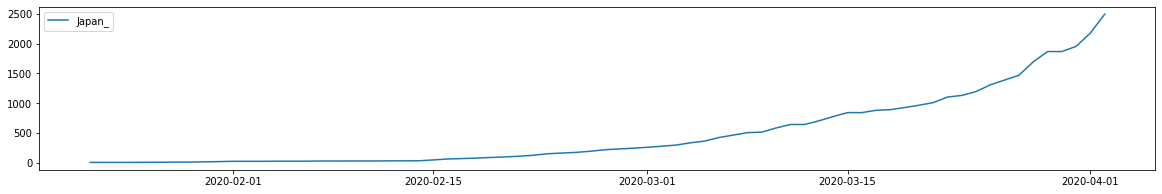

In [118]:
plt.figure(figsize=(20, 3))

plt.plot(ts_train_df.loc['Japan_'], label='Japan_')
plt.legend();

In [119]:
prediction_length = 5

test_data = ts_train_df  # the full data set

train_data = ts_train_df.slice_by_timestep(None, -prediction_length)

## AutoGluonの学習

In [120]:
# 保存するモデルのフォルダー名
save_model = "/conten/autogluon/"

# どこまで先を予測するモデル化を設定
# ここではtest_dfと同じ長さを予測できるようにする
#prediction_length = len(test_df)
#prediction_length = 48

predictor = TimeSeriesPredictor(path = save_model,
                                target="ConfirmedCases",
                                prediction_length=prediction_length,
                                # 評価関数の設定
                                eval_metric="MAPE",
                                ).fit(train_data,
                                      # どれぐらいの精度を出すか
                                      #presets="fast_training",
                                      presets="medium_quality",
                                      #presets= "good_quality",
                                      #presets = 'best_quality',  # かなり時間がかかる
                                      # 予測の時間制限
                                      time_limit=1000,
                                      )


================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'prediction_length': 5,
 'random_seed': None,
 'target': 'ConfirmedCases',
 'time_limit': 1000}
Provided training data set with 67 rows, 1 items (item = single time series). Average time series length is 67.0.
Training artifacts will be saved to: /conten/autogluon
AutoGluon will save models to /conten/autogluon/
AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.
tuning_data is None. Will use the last prediction_length = 5 time steps of each time series as a hold-out validation set.

Starting training. Start time is 2022-12-10 17:56:30
No path spec

In [121]:
predictor.leaderboard(test_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ARIMA,-0.044860,-0.102993,0.175206,0.461098,0.008166,5
1,ETS,-0.044876,-0.095583,0.278321,0.267746,0.004627,3
2,DeepAR,-0.051315,-0.058529,0.063192,0.053458,197.649552,7
3,WeightedEnsemble,-0.099737,-0.025780,0.345412,0.378922,5.428341,8
4,Theta,-0.153398,-0.170328,0.150903,0.171095,0.008004,4
5,Naive,-0.172535,-0.188702,0.026536,0.017887,0.010240,1
6,SeasonalNaive,-0.407721,-0.333375,0.016927,0.025524,0.005540,2
7,AutoGluonTabular,-0.408002,-0.300430,0.079968,0.057718,47.508730,6


## AutoGluonの予測

In [127]:
# 二つ目の引数でモデルを選べる
predictions = predictor.predict(train_data, model="ARIMA")
predictions.head()

mean          0.1          0.2          0.3  \
item_id timestamp                                                        
Japan_  2020-03-29  1829.472724  1796.399464  1807.752835  1815.939414   
        2020-03-30  1964.467279  1907.650239  1927.154362  1941.218207   
        2020-03-31  2098.009966  2016.034875  2044.175240  2064.466423   
        2020-04-01  2230.126616  2121.183975  2158.581746  2185.548171   
        2020-04-02  2360.842604  2223.159536  2270.423306  2304.503809   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
Japan_  2020-03-29  1822.934544  1829.472724  1836.010904  1843.006034   
        2020-03-30  1953.235244  1964.467279  1975.699315  1987.716352   
        2020-03-31  2081.804491  2098.009966  2114.215441  2131.553509   
        2020-04-01  2208.589986  2230.126616  2251.663247  2274.705062   
        2020-04-02  2333.624342  2360.842604  2388.060866  2417.181399   

                            0.8          0.9  
item_id timestamp                             
Japan_  2020-03-29  1851.192613  1862.545984  
        2020-03-30  2001.780197  2021.284320  
        2020-03-31  2151.844692  2179.985057  
        2020-04-01  2301.671487  2339.069258  
        2020-04-02  2451.261902  2498.525671

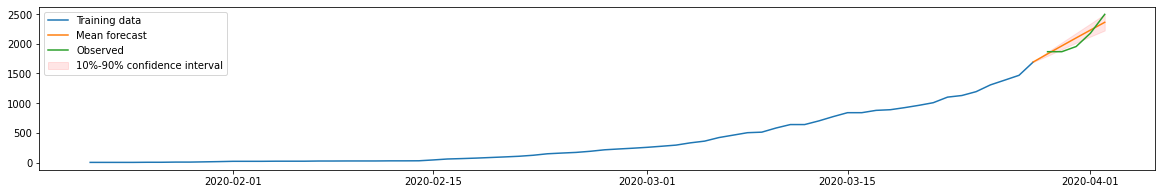

In [128]:
plt.figure(figsize=(20, 3))
prediction_length = 5

item_id = "Japan_"
y_past = train_data.loc[item_id]["ConfirmedCases"]
y_pred = predictions.loc[item_id]
y_true = test_data.loc[item_id]["ConfirmedCases"][-prediction_length:]

# prepend the last value of true range to predicted range for plotting continuity
y_pred.loc[y_past.index[-1]] = [y_past[-1]] * 10
y_pred = y_pred.sort_index()

plt.plot(y_past[-200:], label="Training data")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_true, label="Observed")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();
